In [10]:
import rasterio as rs
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from skimage.restoration import denoise_tv_chambolle

In [11]:
# required files
irr = pd.read_table("ch2_iirs_solar_flux.txt")
zen = pd.read_table("ch2_iir_nci_20191210T1310531966_d_img_d18.oat")
bands_csv = pd.read_csv("ch2_iirs_wavelength.csv")
ch2_wavelengths = [bands_csv['center_wavelength'][i] for i in range(256)]
ch2_wavelengths = np.array(ch2_wavelengths,dtype=int)
ch2_wavelengths = np.sort(ch2_wavelengths)
ch2_wavelengths = ch2_wavelengths[5:108]

In [12]:
ch2_wavelengths = [bands_csv['center_wavelength'][i] for i in range(256)]
new_ch2_wavelengths = []
df = pd.read_csv('Valid_Bands.csv')
for j in range(len(df)):
    if df['Valid'].iloc[j]:
        new_ch2_wavelengths.append(ch2_wavelengths[j])
ch2_wavelengths = new_ch2_wavelengths

In [13]:
# valid bands only
r=rs.open("CH2_Clipped_Gardner.tif")
arr=r.read()

arr1 = []
for j in range(len(df)):
    if df['Valid'].iloc[j]:
        arr1.append(arr[j])
arr1 = np.array(arr1)

# for radiance to reflectance
# solar flux
solar_irradiance = []
for j in range(len(irr)):
    if df['Valid'].iloc[j]:
        solar_irradiance.append(irr.iloc[j,1])
solar_irradiance = np.array(solar_irradiance)

# solar zenith angle
solar_zenith = []
for j in range(len(zen)):
    d = zen.iloc[j,0]
    pattern1 = re.compile(r'\b\w+\b|\b\d+\b')
    pattern2 = re.compile('\d+\.\d+')
    matches1 = re.findall(pattern1, d)[:9]
    matches2 = re.findall(pattern2, d)
    matches2 = np.array(matches2,dtype=np.float32)
    matches2 = matches2.tolist()
    matches1.extend(matches2)
    matches1 = np.array(matches1)
    solar_zenith.append(matches1[-5])
solar_zenith = np.array(solar_zenith,dtype=np.float32)
solar_zenith = solar_zenith*(np.pi/180)
cos_solar_zenith = np.cos(solar_zenith)
zenith = cos_solar_zenith[len(cos_solar_zenith)//2]

rfl = np.zeros(arr1.shape)
elevation = 1
for j in range(arr1.shape[0]):
    temp = arr1[j]
    factor = (np.pi)/((zenith*solar_irradiance[j]*(elevation**2)))
    rfl[j] = temp*factor
print("Radiance to Reflectance Converted")
rfl = rfl/1000

Radiance to Reflectance Converted


In [14]:
rfl = rfl[5:108,:,:]
transposed_rfl=np.transpose(rfl,(1,2,0))
transposed_rfl.shape

(1118, 231, 103)

### Spectral Mean Algorithm

In [15]:
reflectance_smean = np.copy(transposed_rfl)
epoch = 10
window_size = 7
for i in tqdm(range(reflectance_smean.shape[0])):
    for j in range(reflectance_smean.shape[1]):
        arr = np.copy(transposed_rfl[i][j][:])
        e=0
        while(e<epoch):
            # Static Window
            # for m in range(103):
            #     if 103-m==window_size:
            #         break
            #     # val = []
            #     # for j in range(i,i+window_size):
            #     #     val.append(transposed_reflectance[920][210][j])
            #     mean = np.mean([transposed_reflectance[i][j][m:m+window_size]])
            #     arr[m+window_size//2] = mean
            # reflectance_smean[i][j][:] = arr
            # e=e+1
            
            # custom window
            n = transposed_rfl.shape[2]
            for k in range(n//4):
                if 103-k==window_size:
                    break
                mean = np.mean([transposed_rfl[i][j][k:k+window_size//2]])
                arr[k+(window_size//2)//2] = mean
            for k in range(n//4,(3*n)//4):
                if 103-k==window_size:
                    break
                mean = np.mean([transposed_rfl[i][j][k:k+window_size]])
                arr[k+window_size//2] = mean
            for k in range((3*n)//4,n):
                if 103-k==window_size:
                    break
                mean = np.mean([transposed_rfl[i][j][k:k+window_size//2]])
                arr[k+window_size//4] = mean
            reflectance_smean[i][j][:] = arr
            e=e+1
    j=j+1

100%|██████████| 1118/1118 [40:00<00:00,  2.15s/it]


In [16]:
transposed_reflectance_smean = np.transpose(reflectance_smean,(2,0,1))

In [17]:
transposed_reflectance_smean.shape

(103, 1118, 231)

In [18]:
den_final = denoise_tv_chambolle(transposed_reflectance_smean,weight=5,max_num_iter=40)

In [21]:
len(ch2_wavelengths)

222

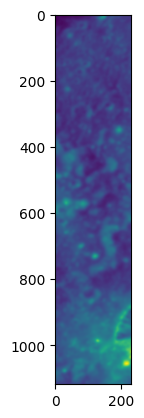

In [22]:
plt.imshow(den_final[20])

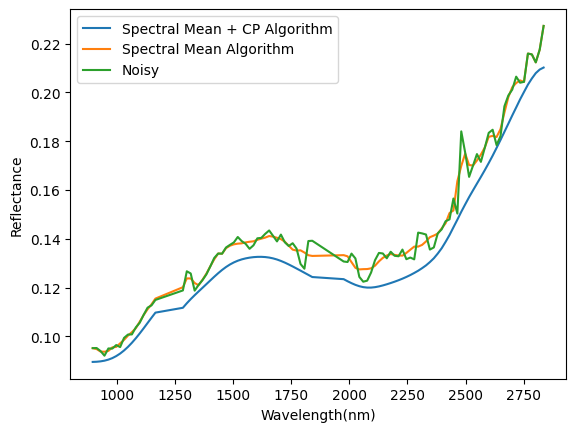

In [29]:
plt.plot(ch2_wavelengths[5:108], den_final[:,910,220])
plt.plot(ch2_wavelengths[5:108], transposed_reflectance_smean[:,910,220])
plt.plot(ch2_wavelengths[5:108], rfl[:,910,220])
plt.legend(["Spectral Mean + CP Algorithm","Spectral Mean Algorithm","Noisy"])
plt.xlabel("Wavelength(nm)")
plt.ylabel("Reflectance")
plt.savefig("Results_Comparison.png",dpi=800)
plt.show()

### PSNR - Peak Signal to Noise Ratio

In [30]:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = np.amax(original)
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

value = PSNR(den_final,rfl)
print(f"PSNR value is {value} dB")

PSNR value is 34.558266896983895 dB


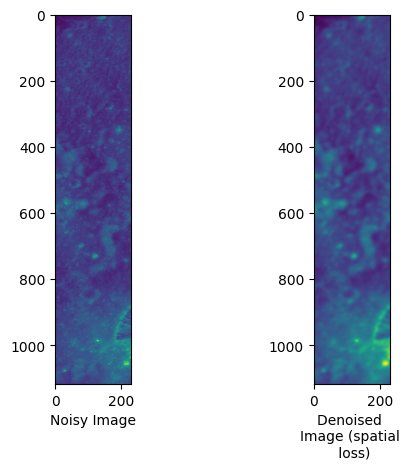

In [40]:
plt.subplot(1,4,1)
plt.imshow(rfl[20])
plt.xlabel("Noisy Image")
plt.subplot(1,4,3)
plt.imshow(den_final[20])
plt.xlabel("Denoised \nImage (spatial \n loss)")
plt.savefig("Spatial_Image_Comparison.png",dpi = 800)